In this recipe we'll explore some of the functionality that can be applied to an alignment of protein sequences. We're going to start with a multiple sequence alignment (MSA) of myoglobin sequences from 42 diverse tetrapods, and one human hemoglobin sequence. This multiple sequence alignment was generated by following the steps in the [Progressive Multiple Sequence Alignment recipe](./Progressive%20multiple%20sequence%20alignment.ipynb).

Myoglobin was the first protein sequence to have its stucture determined by x-ray crystallography. For some background on this molecule, see the [myoglobin article in the PDB *Molecule of the Month* series](http://www.rcsb.org/pdb/101/motm.do?momID=1).

First, we'll prepare our environment and load our myoglobin alignment into a [scikit-bio ``Alignment`` object](http://scikit-bio.org/docs/latest/generated/skbio.alignment.Alignment.html).

In [1]:
%matplotlib inline

from skbio import Alignment, Protein

aln = Alignment.read('data/globin-aln.fasta', constructor=Protein)

## Exploring a sequence alignment

We can next get some information about this alignment. For example, we can easily see that there are 43 sequences in this alignment, and that it's 154 characters long. By definition, there is no variance in sequence length in an alignment, hence the standard deviation of 0.00. For this reason, it's common to think of an alignment as a matrix, where rows represent sequences and columns represent positions in the sequences.

In [2]:
aln

<Alignment: n=43; mean +/- std length=154.00 +/- 0.00>

There are also some mechanisms in place to get more direct access to this information. For example:

In [3]:
aln.sequence_count()

43

In [4]:
aln.sequence_length()

154

In [5]:
sequence_count, sequence_length, sequence_length_std = aln.distribution_stats()
print(sequence_count, sequence_length, sequence_length_std)

(43, 154.0, 0.0)


The sequence identifiers in this alignment contain the genus and species that each sequence is dervied from. We can see what those are by printing the ids.

In [6]:
for e in aln.ids():
    print(e)

hemoglobin-human
Ornithorhynchus.anatinus-platypus
Tachyglossus.aculeatus-short.beaked.echidna
Macropus.rufus-red.kangaroo
Castor.fiber-eurasian.beaver
Ondatra.zibethicus-muskrat
Kogia.breviceps-pygmy.sperm.whale
Physeter.catodon-sperm.whale
Ziphius.cavirostris-beaked.whale
Orcinus.orca-killer.whale
Phocoenoides.dalli.dalli-porpoise
Balaenoptera.physalus-fin-whale
Inia.geoffrensis-amazon.river.dolphin
Canis.lupus.familiaris.dog
Bos.taurus-cattle
Ovis.aries-sheep
Elephas.maximus-asian.elephant
Equus.caballus-horse
Mus.musculus-mouse
Zalophus.californianus-california.sea.lion
Orycteropus.afer-aardvark
Ctenodactylus.gundi-common.gundi
Tupaia.chinensis-treeshrew
Lagostomus.maximus-viscacha
Proechimys.guairae-guaira.spiny.rat
Ochotona.princeps-american.pika
Nannospalax.ehrenbergi-blind.mole.rat
Lutra.lutra-otter
Meles.meles-badger
Didelphis.virginiana-opossum
Callithrix.jacchus-marmoset
Lagothrix.lagotricha-brown.woolly.monkey
Saimiri.sciureus-common.squirrel.monkey
Rousettus.aegyptiacus-eg

We can also explore some more interesting features of this alignment. For example, we can compute the positional entropy, which is the Shannon entropy (usually abbreviated as ``H``) at each position (or column) in the alignment. In this case, we're going to treat gap characters as another *character* in the amino acid alphabet, though the right way to handle gaps in alignments when computing entropy is debatable. 

To learn more about positional entropy and information theory, see the references in the ``Alignment.positional_entropies`` help text, either on the scikit-bio website [here](http://scikit-bio.org/docs/latest/generated/skbio.alignment.Alignment.position_entropies.html) or by calling  ``help(Alignment.positional_entropies)`` in this notebook.

To keep our entropy values in the range of zero to one, we're going to pass ``base=21`` here. This is the number of characters in the canonical amino acid alphabet (20) plus the gap character. 

We can get a list of the positional entropies back (here we'll just print the first ten). A high entropy value means that there is a lot of variation in the sequences at the corresponding position in the alignment, while a low entropy value means that the corresponding position in the alignment is highly conserved. An entropy of zero means that a position is perfectly conserved (i.e., it's the same in all positions in the alignment). An entropy of one means that every character in the alphabet is present in exactly equal frequency at that position in the alignment (this is uncommon in practice).

In [7]:
entropies = aln.position_entropies(base=21, nan_on_non_standard_chars=False)
entropies[:10]

[0.036279268401513444,
 0.15435646524373836,
 0.0,
 0.097698390063509652,
 0.13717470781508639,
 0.28249432209370146,
 0.0,
 0.036279268401513444,
 0.22879316284005818,
 0.26921145385848555]

In our alignment, there are exactly 21 positions that are perfectly conserved across all sequences. This is pretty astonishing, particularly because there is a hemoglobin sequence in the alignment. This means that (based on the information we have here) these positions have not changed since the last common ancestor of the hemoglobin/myoglobin <a href="http://en.wikipedia.org/wiki/Homology_(biology)#Paralogy">paralogs</a>). 

In [8]:
entropies.count(0)

21

Let's figure out what amino acids are at these highly conserved positions. To do this, we'll first get the frequency of each amino acid at each position:

In [9]:
position_frequencies = aln.position_frequencies()
for e in position_frequencies[:10]:
    print(e)

defaultdict(<type 'float'>, {'-': 0.9767441860465116, 'V': 0.023255813953488372})
defaultdict(<type 'float'>, {'H': 0.023255813953488372, 'E': 0.023255813953488372, 'G': 0.8837209302325582, 'V': 0.06976744186046512})
defaultdict(<type 'float'>, {'L': 1.0})
defaultdict(<type 'float'>, {'S': 0.9302325581395349, 'T': 0.046511627906976744, 'N': 0.023255813953488372})
defaultdict(<type 'float'>, {'P': 0.023255813953488372, 'E': 0.09302325581395349, 'D': 0.8837209302325582})
defaultdict(<type 'float'>, {'A': 0.06976744186046512, 'Q': 0.06976744186046512, 'E': 0.046511627906976744, 'D': 0.046511627906976744, 'G': 0.7674418604651163})
defaultdict(<type 'float'>, {'E': 1.0})
defaultdict(<type 'float'>, {'K': 0.023255813953488372, 'W': 0.9767441860465116})
defaultdict(<type 'float'>, {'E': 0.023255813953488372, 'H': 0.046511627906976744, 'K': 0.046511627906976744, 'N': 0.023255813953488372, 'Q': 0.8372093023255814, 'S': 0.023255813953488372})
defaultdict(<type 'float'>, {'A': 0.02325581395348837

Then we'll print out the amino acid found at a position, for all positions with zero entropy.

In [10]:
for i in range(aln.sequence_length()):
    if entropies[i] == 0.0:
        # find the amino acid at this position in the first sequence in the alignment
        aa = aln[0][i]
        print("Position %3d is perfectly conserved, containing %s in all sequences." % (i, aa))

Position   2 is perfectly conserved, containing L in all sequences.
Position   6 is perfectly conserved, containing E in all sequences.
Position  10 is perfectly conserved, containing V in all sequences.
Position  14 is perfectly conserved, containing W in all sequences.
Position  16 is perfectly conserved, containing K in all sequences.
Position  17 is perfectly conserved, containing V in all sequences.
Position  25 is perfectly conserved, containing G in all sequences.
Position  37 is perfectly conserved, containing P in all sequences.
Position  39 is perfectly conserved, containing T in all sequences.
Position  43 is perfectly conserved, containing F in all sequences.
Position  46 is perfectly conserved, containing F in all sequences.
Position  62 is perfectly conserved, containing K in all sequences.
Position  65 is perfectly conserved, containing G in all sequences.
Position  68 is perfectly conserved, containing V in all sequences.
Position  76 is perfectly conserved, containing 

Finally we can visualize the entropies along the full length of the alignment to get an idea of where the more and less conserved positions are found. In general, positions that are highly conserved are thought to have specific structural or functional roles in the protein, while positions that are less conserved might have less specific roles (e.g., providing a filler between two functional domains in the linear protein backbone).

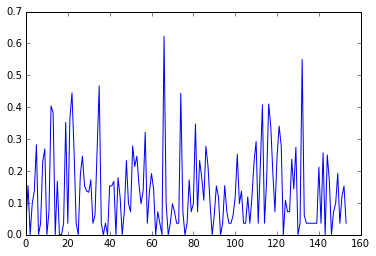

In [11]:
from pylab import figure

fig = figure()
ax = fig.add_subplot(111)
ax.plot(range(len(entropies)), entropies, '-')

## Building a neighbor joining tree

A common reason for building a multiple sequence alignment is for making an inference about the evolutionary relationships between the organisms. We'll do this here using the neighbor joining ([``nj``](http://scikit-bio.org/docs/latest/generated/skbio.tree.nj.html)) function in scikit-bio.

The input to ``nj`` is a distance matrix, representing the pairwise distances between the sequences in the alignment. This can be obtained using the ``distances`` method, which by default will compute the Hamming distances between all pairs of sequences in the alignment:

In [12]:
dm = aln.distances()
print(dm)

43x43 distance matrix
IDs:
u'hemoglobin-human', u'Ornithorhynchus.anatinus-platypus', ...
Data:
[[ 0.          0.73376623  0.74025974 ...,  0.71428571  0.70779221
   0.70779221]
 [ 0.73376623  0.          0.05844156 ...,  0.24025974  0.30519481
   0.2987013 ]
 [ 0.74025974  0.05844156  0.         ...,  0.24675325  0.31818182
   0.31168831]
 ..., 
 [ 0.71428571  0.24025974  0.24675325 ...,  0.          0.24025974
   0.25324675]
 [ 0.70779221  0.30519481  0.31818182 ...,  0.24025974  0.          0.05194805]
 [ 0.70779221  0.2987013   0.31168831 ...,  0.25324675  0.05194805  0.        ]]


One initial observation that we can make here is that the mean of the distribution of distances between the hemoglobin sequence and all other sequences is higher than the mean of the distribution of the chimpanzee myoglobin sequences to all of the others. This is exactly what we expect since the hemoglobin sequence diverged from the myoglobin sequences longer ago.

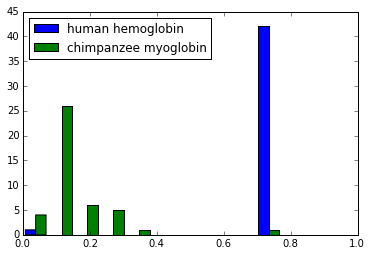

In [13]:
fig = figure()
ax = fig.add_subplot(111)
ax.hist([dm['hemoglobin-human'], dm['Pan.troglodytes-chimpanzee']], label=['human hemoglobin', 'chimpanzee myoglobin'])
ax.set_xlim((0,1))
ax.legend(loc='upper left')

We can now build a neighbor joining tree from this distance matrix. At this point we don't have an easy and good visualization approach in scikit-bio for phylogenetic trees, though we're working on a solution. You can track progress on that [here](https://github.com/biocore/scikit-bio/issues/531).

In the meantime, we're going to export a newick-formatted version of the tree which can be opened with a phylogenetic tree viewing program. We'll show some exported images that we obtained using [Archeoptyrx](https://sites.google.com/site/cmzmasek/home/software/archaeopteryx), which works on OS X, Windows, and Linux, but there are many popular tree viewing programs, and most support the newick file format. A popular one for OS X is [FigTree](http://tree.bio.ed.ac.uk/software/figtree/). 

First, let's build the neighbor-joining tree:

In [14]:
from skbio.tree import nj
tree = nj(dm)

We can then write this to file in newick format:

In [15]:
tree.write('globin-aln.ph')

'globin-aln.ph'

External to scikit-bio, we next opened this in Archeoptryx to visualize the tree and exported the following figure:

![](./assets/globin-aln.png)

To get a better understanding of the evolutionary history, we can use outgroup rooting to place a root in the tree. When doing outgroup rooting, you want to find the tip corresponding to the most distantly related sequence in the alignment, and look at its most recent ancestral node. Because we know *a priori* that the hemoglobin sequence is the most distantly related of the sequences in our alignment (because it's not myoglobin, so by definition had to have begun diverging before all of our myoglobin sequences began diverging), you know that its first ancestral node should be the common ancestor of all sequences in the tree.

First we find the node that we want to be the new root.

In [16]:
new_root = tree.find('hemoglobin-human').ancestors()[0]

And then we build a new tree rooted at this node, and write that to a new file.

In [17]:
tree.root_at(new_root).write('globin-aln.outgroup-rooted.ph')

'globin-aln.outgroup-rooted.ph'

Again, external to scikit-bio, we're visualizing this file with Archeopteryx. You can see that this actually gives us a pretty good picture of the relationships between the organisms. For example, notice that the deepest splits are the myoglobin versus hemoglobin clades, then the separation of the reptiles, birds, and egg-laying mammals, respectively.

![](./assets/globin-aln.outgroup-rooted.png)